# Multi-regression of the metabolites concentrations

## Install required python modules

In [22]:
%%bash
pip install -e ../.

Obtaining file:///data/ar1220/MscProjectNMR
  Attempting uninstall: MscProjectNMR
    Found existing installation: MscProjectNMR 0
    Uninstalling MscProjectNMR-0:
      Successfully uninstalled MscProjectNMR-0
  Running setup.py develop for MscProjectNMR


In [ ]:
%%bash
pip install -r ../requirements.txt

## Import data

In [1]:
import numpy as np

filename_spectrum = '../data/concentration_data/Spectra_Mixt1.txt'
filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
data_spectrum = np.loadtxt(filename_spectrum, dtype=float)
data_concentrations = np.loadtxt(filename_concentrations, delimiter='\t', dtype=float,
                                usecols=range(1,data_spectrum.shape[1]+1))

In [2]:
data_concentrations.shape

(48, 1000)

In [3]:
#Convert into dataframes
import pandas as pd

df_spectrum = pd.DataFrame(data_spectrum).T
df_concentrations = pd.DataFrame(data_concentrations).T

In [4]:
#Convert into tf.data
import tensorflow as tf

dataset = tf.data.Dataset.from_tensor_slices((df_spectrum, df_concentrations))
dataset.element_spec

(TensorSpec(shape=(10000,), dtype=tf.float64, name=None),
 TensorSpec(shape=(48,), dtype=tf.float64, name=None))

## Write tf.Record

In [5]:
from tfrecords import write_tfrecords_concentrations

In [6]:
write_tfrecords_concentrations('../data/tfrecords/Concentrations_data', dataset=dataset, number=10)

## Read the file

In [1]:
from tfrecords import read_tfrecords_concentrations

In [2]:
file_paths = ['../data/tfrecords/Concentrations_data/data_{}.tfrecord'.format(i) for i in range(10)]
full_dataset = read_tfrecords_concentrations(file_paths)

## Process data

In [3]:
from models import process_dataset

In [4]:
train_dataset, val_dataset, test_dataset = process_dataset(full_dataset, batch_sizes=[64] * 3, shuffle_buffers=[1000] * 3,
                                                           train_prop=0.8, val_prop=0.2)

## Define Checkpoint

In [14]:
from models import CheckpointCallback

# Create a CheckpointCallback to save the model    
ckpt = CheckpointCallback("../saved_models")

## Define MLP

In [19]:
from models import get_simple_mlp_concentrations

simple_model = get_simple_mlp_concentrations(input_shape=(10000,), hidden_units=[16, 16])
simple_model.summary()

Model: "functional_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_20 (Dense)             (None, 16)                160016    
_________________________________________________________________
dense_21 (Dense)             (None, 16)                272       
_________________________________________________________________
dense_22 (Dense)             (None, 48)                816       
Total params: 161,104
Trainable params: 161,104
Non-trainable params: 0
_________________________________________________________________


In [20]:
from models import get_regularised_bn_dropout_mlp_concentrations

regularised_bn_dropout_model = get_regularised_bn_dropout_mlp_concentrations(input_shape=(10000,), hidden_units=[1024, 1024, 1024, 512, 512, 512],
                                l2_reg_coeff=0.0001, dropout_rate=0.5)
regularised_bn_dropout_model.summary()

Model: "functional_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 10000)]           0         
_________________________________________________________________
dense_23 (Dense)             (None, 1024)              10241024  
_________________________________________________________________
batch_normalization_12 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_12 (Dropout)         (None, 1024)              0         
_________________________________________________________________
dense_24 (Dense)             (None, 1024)              1049600   
_________________________________________________________________
batch_normalization_13 (Batc (None, 1024)              4096      
_________________________________________________________________
dropout_13 (Dropout)         (None, 1024)            

## Compile models

In [21]:
import tensorflow as tf
opt = tf.keras.optimizers.Adam(lr=0.0005)
loss = tf.keras.losses.MeanAbsoluteError()
acc = tf.keras.metrics.MeanSquaredError()
earlystopping = tf.keras.callbacks.EarlyStopping(patience=200)

In [22]:
simple_model.compile(optimizer=opt, loss=loss, metrics=[acc])
history = simple_model.fit(train_dataset, epochs=1000, validation_data=val_dataset, callbacks=[ckpt])

Epoch 1/1000
13/13 [==============================] - 0s 28ms/step - loss: 955.5444 - mean_squared_error: 7068499.0000 - val_loss: 939.4905 - val_mean_squared_error: 6991422.5000
Epoch 2/1000
13/13 [==============================] - 0s 19ms/step - loss: 931.9777 - mean_squared_error: 6689211.0000 - val_loss: 912.0834 - val_mean_squared_error: 6284168.5000
Epoch 3/1000
13/13 [==============================] - 0s 22ms/step - loss: 908.3133 - mean_squared_error: 6549164.0000 - val_loss: 896.7433 - val_mean_squared_error: 6524103.5000
Epoch 4/1000
13/13 [==============================] - 0s 19ms/step - loss: 884.9732 - mean_squared_error: 6375345.5000 - val_loss: 870.4842 - val_mean_squared_error: 6240141.0000
Epoch 5/1000
13/13 [==============================] - 0s 22ms/step - loss: 862.5121 - mean_squared_error: 6237530.0000 - val_loss: 861.2848 - val_mean_squared_error: 6412630.0000
Epoch 6/1000
13/13 [==============================] - 0s 20ms/step - loss: 832.1207 - mean_squared_error:

Epoch 47/1000
13/13 [==============================] - 0s 24ms/step - loss: 426.9416 - mean_squared_error: 767704.1875 - val_loss: 433.1607 - val_mean_squared_error: 785719.8125
Epoch 48/1000
13/13 [==============================] - 0s 23ms/step - loss: 428.7846 - mean_squared_error: 770841.0625 - val_loss: 429.7450 - val_mean_squared_error: 790668.2500
Epoch 49/1000
13/13 [==============================] - 0s 21ms/step - loss: 426.4390 - mean_squared_error: 752462.3750 - val_loss: 426.8570 - val_mean_squared_error: 751382.3750
Epoch 50/1000
13/13 [==============================] - 0s 22ms/step - loss: 429.2242 - mean_squared_error: 760126.2500 - val_loss: 432.4972 - val_mean_squared_error: 743958.0625
Epoch 51/1000
13/13 [==============================] - 0s 20ms/step - loss: 424.7619 - mean_squared_error: 731096.3125 - val_loss: 426.5759 - val_mean_squared_error: 746025.2500
Epoch 52/1000
13/13 [==============================] - 0s 24ms/step - loss: 427.6905 - mean_squared_error: 740

13/13 [==============================] - 0s 21ms/step - loss: 421.4961 - mean_squared_error: 729097.8125 - val_loss: 399.1171 - val_mean_squared_error: 624673.2500
Epoch 94/1000
13/13 [==============================] - 0s 19ms/step - loss: 416.0133 - mean_squared_error: 703936.1875 - val_loss: 417.2902 - val_mean_squared_error: 695444.5000
Epoch 95/1000
13/13 [==============================] - 0s 21ms/step - loss: 418.3550 - mean_squared_error: 712804.9375 - val_loss: 405.2175 - val_mean_squared_error: 666128.7500
Epoch 96/1000
13/13 [==============================] - 0s 20ms/step - loss: 417.6882 - mean_squared_error: 710950.7500 - val_loss: 410.6808 - val_mean_squared_error: 699011.1250
Epoch 97/1000
13/13 [==============================] - 0s 23ms/step - loss: 417.1738 - mean_squared_error: 709925.6250 - val_loss: 413.4455 - val_mean_squared_error: 698925.0625
Epoch 98/1000
13/13 [==============================] - 0s 21ms/step - loss: 416.8701 - mean_squared_error: 698921.0625 - val

Epoch 139/1000
13/13 [==============================] - 0s 19ms/step - loss: 411.7958 - mean_squared_error: 714579.6875 - val_loss: 421.4675 - val_mean_squared_error: 759080.8125
Epoch 140/1000
13/13 [==============================] - 0s 20ms/step - loss: 409.2096 - mean_squared_error: 702491.4375 - val_loss: 410.2460 - val_mean_squared_error: 694162.9375
Epoch 141/1000
13/13 [==============================] - 0s 20ms/step - loss: 408.4585 - mean_squared_error: 709317.6250 - val_loss: 418.4879 - val_mean_squared_error: 759106.6250
Epoch 142/1000
13/13 [==============================] - 0s 20ms/step - loss: 408.3090 - mean_squared_error: 708394.5625 - val_loss: 401.6675 - val_mean_squared_error: 684703.7500
Epoch 143/1000
13/13 [==============================] - 0s 19ms/step - loss: 408.2415 - mean_squared_error: 702905.1250 - val_loss: 403.3031 - val_mean_squared_error: 683548.0625
Epoch 144/1000
13/13 [==============================] - 0s 20ms/step - loss: 407.9307 - mean_squared_erro

Epoch 185/1000
13/13 [==============================] - 0s 20ms/step - loss: 390.9249 - mean_squared_error: 673563.1250 - val_loss: 377.1988 - val_mean_squared_error: 623037.8125
Epoch 186/1000
13/13 [==============================] - 0s 20ms/step - loss: 391.8751 - mean_squared_error: 673391.5000 - val_loss: 395.4222 - val_mean_squared_error: 694469.3750
Epoch 187/1000
13/13 [==============================] - 0s 20ms/step - loss: 393.0671 - mean_squared_error: 682957.3750 - val_loss: 385.7502 - val_mean_squared_error: 666655.6250
Epoch 188/1000
13/13 [==============================] - 0s 19ms/step - loss: 389.9484 - mean_squared_error: 667448.8125 - val_loss: 385.2302 - val_mean_squared_error: 659005.1875
Epoch 189/1000
13/13 [==============================] - 0s 19ms/step - loss: 391.7199 - mean_squared_error: 677770.6250 - val_loss: 378.8744 - val_mean_squared_error: 607926.7500
Epoch 190/1000
13/13 [==============================] - 0s 21ms/step - loss: 391.3407 - mean_squared_erro

Epoch 231/1000
13/13 [==============================] - 0s 25ms/step - loss: 373.9688 - mean_squared_error: 614755.4375 - val_loss: 375.2047 - val_mean_squared_error: 609599.5000
Epoch 232/1000
13/13 [==============================] - 0s 23ms/step - loss: 375.7599 - mean_squared_error: 620395.5000 - val_loss: 358.6970 - val_mean_squared_error: 559442.5000
Epoch 233/1000
13/13 [==============================] - 0s 20ms/step - loss: 373.1617 - mean_squared_error: 606823.1875 - val_loss: 378.5800 - val_mean_squared_error: 647440.0000
Epoch 234/1000
13/13 [==============================] - 0s 20ms/step - loss: 372.2644 - mean_squared_error: 606631.3750 - val_loss: 367.9219 - val_mean_squared_error: 588141.0000
Epoch 235/1000
13/13 [==============================] - 0s 21ms/step - loss: 371.5052 - mean_squared_error: 608931.8125 - val_loss: 373.1666 - val_mean_squared_error: 614913.6875
Epoch 236/1000
13/13 [==============================] - 0s 23ms/step - loss: 373.3053 - mean_squared_erro

Epoch 277/1000
13/13 [==============================] - 0s 22ms/step - loss: 359.7245 - mean_squared_error: 543933.9375 - val_loss: 361.9224 - val_mean_squared_error: 549390.7500
Epoch 278/1000
13/13 [==============================] - 0s 24ms/step - loss: 359.5281 - mean_squared_error: 544716.6250 - val_loss: 361.8873 - val_mean_squared_error: 562129.3750
Epoch 279/1000
13/13 [==============================] - 0s 25ms/step - loss: 358.7248 - mean_squared_error: 546323.0000 - val_loss: 357.9182 - val_mean_squared_error: 535821.7500
Epoch 280/1000
13/13 [==============================] - 0s 21ms/step - loss: 356.4026 - mean_squared_error: 538640.4375 - val_loss: 356.4562 - val_mean_squared_error: 527047.3750
Epoch 281/1000
13/13 [==============================] - 0s 21ms/step - loss: 360.7415 - mean_squared_error: 553778.1250 - val_loss: 355.9856 - val_mean_squared_error: 523068.5312
Epoch 282/1000
13/13 [==============================] - 0s 22ms/step - loss: 359.4000 - mean_squared_erro

Epoch 323/1000
13/13 [==============================] - 0s 25ms/step - loss: 352.4486 - mean_squared_error: 500815.7500 - val_loss: 355.8373 - val_mean_squared_error: 505012.4375
Epoch 324/1000
13/13 [==============================] - 0s 21ms/step - loss: 351.9385 - mean_squared_error: 496391.4688 - val_loss: 350.0777 - val_mean_squared_error: 491683.1875
Epoch 325/1000
13/13 [==============================] - 0s 25ms/step - loss: 352.6304 - mean_squared_error: 501428.8125 - val_loss: 354.7545 - val_mean_squared_error: 508337.9062
Epoch 326/1000
13/13 [==============================] - 0s 18ms/step - loss: 352.0652 - mean_squared_error: 505029.4688 - val_loss: 350.2043 - val_mean_squared_error: 498598.8125
Epoch 327/1000
13/13 [==============================] - 0s 19ms/step - loss: 350.5924 - mean_squared_error: 492958.1562 - val_loss: 351.3863 - val_mean_squared_error: 504304.6250
Epoch 328/1000
13/13 [==============================] - 0s 19ms/step - loss: 352.1875 - mean_squared_erro

Epoch 369/1000
13/13 [==============================] - 0s 24ms/step - loss: 346.8277 - mean_squared_error: 467310.5312 - val_loss: 350.5074 - val_mean_squared_error: 486938.9062
Epoch 370/1000
13/13 [==============================] - 0s 23ms/step - loss: 350.7241 - mean_squared_error: 482775.7500 - val_loss: 344.3619 - val_mean_squared_error: 466976.7188
Epoch 371/1000
13/13 [==============================] - 0s 19ms/step - loss: 347.5089 - mean_squared_error: 471497.6250 - val_loss: 350.5260 - val_mean_squared_error: 480863.8438
Epoch 372/1000
13/13 [==============================] - 0s 22ms/step - loss: 346.7186 - mean_squared_error: 467076.8750 - val_loss: 347.9398 - val_mean_squared_error: 472185.5312
Epoch 373/1000
13/13 [==============================] - 0s 22ms/step - loss: 347.3574 - mean_squared_error: 471100.0938 - val_loss: 351.5629 - val_mean_squared_error: 488573.7188
Epoch 374/1000
13/13 [==============================] - 0s 27ms/step - loss: 347.6000 - mean_squared_erro

Epoch 415/1000
13/13 [==============================] - 0s 21ms/step - loss: 344.6924 - mean_squared_error: 459816.4375 - val_loss: 343.8963 - val_mean_squared_error: 439710.2500
Epoch 416/1000
13/13 [==============================] - 0s 21ms/step - loss: 345.3877 - mean_squared_error: 458388.1250 - val_loss: 350.9449 - val_mean_squared_error: 490253.2500
Epoch 417/1000
13/13 [==============================] - 0s 22ms/step - loss: 345.9537 - mean_squared_error: 462310.4375 - val_loss: 343.0938 - val_mean_squared_error: 452310.6250
Epoch 418/1000
13/13 [==============================] - 0s 22ms/step - loss: 344.6256 - mean_squared_error: 456800.8125 - val_loss: 343.1354 - val_mean_squared_error: 446849.5938
Epoch 419/1000
13/13 [==============================] - 0s 22ms/step - loss: 344.9159 - mean_squared_error: 459846.8438 - val_loss: 349.9961 - val_mean_squared_error: 480670.1250
Epoch 420/1000
13/13 [==============================] - 0s 23ms/step - loss: 343.7166 - mean_squared_erro

Epoch 461/1000
13/13 [==============================] - 0s 23ms/step - loss: 341.8378 - mean_squared_error: 443919.3750 - val_loss: 347.8689 - val_mean_squared_error: 457422.5938
Epoch 462/1000
13/13 [==============================] - 0s 22ms/step - loss: 344.9139 - mean_squared_error: 457383.4375 - val_loss: 342.3785 - val_mean_squared_error: 440948.8125
Epoch 463/1000
13/13 [==============================] - 0s 20ms/step - loss: 344.0966 - mean_squared_error: 450207.1875 - val_loss: 344.8488 - val_mean_squared_error: 439664.4062
Epoch 464/1000
13/13 [==============================] - 0s 22ms/step - loss: 344.5603 - mean_squared_error: 454553.1875 - val_loss: 343.1019 - val_mean_squared_error: 459279.6250
Epoch 465/1000
13/13 [==============================] - 0s 21ms/step - loss: 344.3559 - mean_squared_error: 455030.6875 - val_loss: 346.1736 - val_mean_squared_error: 468723.0938
Epoch 466/1000
13/13 [==============================] - 0s 19ms/step - loss: 344.1660 - mean_squared_erro

Epoch 507/1000
13/13 [==============================] - 0s 22ms/step - loss: 342.8896 - mean_squared_error: 449215.1875 - val_loss: 347.1333 - val_mean_squared_error: 469727.3750
Epoch 508/1000
13/13 [==============================] - 0s 19ms/step - loss: 342.2381 - mean_squared_error: 450790.8125 - val_loss: 342.7888 - val_mean_squared_error: 445514.9688
Epoch 509/1000
13/13 [==============================] - 0s 18ms/step - loss: 341.7641 - mean_squared_error: 443045.4062 - val_loss: 343.8673 - val_mean_squared_error: 453247.5312
Epoch 510/1000
13/13 [==============================] - 0s 21ms/step - loss: 342.5376 - mean_squared_error: 449206.5625 - val_loss: 344.0946 - val_mean_squared_error: 442141.8750
Epoch 511/1000
13/13 [==============================] - 0s 21ms/step - loss: 342.9419 - mean_squared_error: 445003.4375 - val_loss: 341.6446 - val_mean_squared_error: 435056.1250
Epoch 512/1000
13/13 [==============================] - 0s 21ms/step - loss: 342.9475 - mean_squared_erro

Epoch 553/1000
13/13 [==============================] - 0s 21ms/step - loss: 341.3321 - mean_squared_error: 441984.0000 - val_loss: 337.2764 - val_mean_squared_error: 436598.4688
Epoch 554/1000
13/13 [==============================] - 0s 23ms/step - loss: 341.9817 - mean_squared_error: 445401.1250 - val_loss: 345.0026 - val_mean_squared_error: 455429.7500
Epoch 555/1000
13/13 [==============================] - 0s 18ms/step - loss: 342.0752 - mean_squared_error: 443701.8125 - val_loss: 342.7675 - val_mean_squared_error: 465360.3125
Epoch 556/1000
13/13 [==============================] - 0s 18ms/step - loss: 339.8734 - mean_squared_error: 440567.3125 - val_loss: 345.1877 - val_mean_squared_error: 451967.0938
Epoch 557/1000
13/13 [==============================] - 0s 18ms/step - loss: 341.7910 - mean_squared_error: 444636.0312 - val_loss: 338.6100 - val_mean_squared_error: 441654.9688
Epoch 558/1000
13/13 [==============================] - 0s 20ms/step - loss: 340.9524 - mean_squared_erro

Epoch 599/1000
13/13 [==============================] - 0s 20ms/step - loss: 340.5589 - mean_squared_error: 441119.1562 - val_loss: 340.0744 - val_mean_squared_error: 444687.2500
Epoch 600/1000
13/13 [==============================] - 0s 21ms/step - loss: 341.1028 - mean_squared_error: 443873.1875 - val_loss: 338.8340 - val_mean_squared_error: 413359.0000
Epoch 601/1000
13/13 [==============================] - 0s 19ms/step - loss: 342.1628 - mean_squared_error: 447604.0938 - val_loss: 337.8340 - val_mean_squared_error: 436491.5312
Epoch 602/1000
13/13 [==============================] - 0s 20ms/step - loss: 342.1720 - mean_squared_error: 448734.7500 - val_loss: 344.9227 - val_mean_squared_error: 447404.1875
Epoch 603/1000
13/13 [==============================] - 0s 21ms/step - loss: 341.3718 - mean_squared_error: 442986.0938 - val_loss: 340.5618 - val_mean_squared_error: 454857.8438
Epoch 604/1000
13/13 [==============================] - 0s 21ms/step - loss: 340.2927 - mean_squared_erro

Epoch 645/1000
13/13 [==============================] - 0s 22ms/step - loss: 339.7025 - mean_squared_error: 437702.1250 - val_loss: 339.9037 - val_mean_squared_error: 445177.4688
Epoch 646/1000
13/13 [==============================] - 0s 18ms/step - loss: 340.4557 - mean_squared_error: 439943.3125 - val_loss: 342.5320 - val_mean_squared_error: 450966.7188
Epoch 647/1000
13/13 [==============================] - 0s 21ms/step - loss: 340.4187 - mean_squared_error: 441869.2500 - val_loss: 342.8875 - val_mean_squared_error: 444057.5938
Epoch 648/1000
13/13 [==============================] - 0s 21ms/step - loss: 339.8077 - mean_squared_error: 440884.4062 - val_loss: 346.6914 - val_mean_squared_error: 465165.0000
Epoch 649/1000
13/13 [==============================] - 0s 21ms/step - loss: 341.7263 - mean_squared_error: 447951.1250 - val_loss: 337.5346 - val_mean_squared_error: 425134.5625
Epoch 650/1000
13/13 [==============================] - 0s 20ms/step - loss: 338.9058 - mean_squared_erro

Epoch 691/1000
13/13 [==============================] - 0s 21ms/step - loss: 338.3185 - mean_squared_error: 435160.6250 - val_loss: 334.6634 - val_mean_squared_error: 424869.7500
Epoch 692/1000
13/13 [==============================] - 0s 19ms/step - loss: 337.2694 - mean_squared_error: 434380.7188 - val_loss: 339.8090 - val_mean_squared_error: 446692.0312
Epoch 693/1000
13/13 [==============================] - 0s 21ms/step - loss: 339.2045 - mean_squared_error: 438182.9688 - val_loss: 330.7099 - val_mean_squared_error: 409573.4062
Epoch 694/1000
13/13 [==============================] - 0s 21ms/step - loss: 339.7497 - mean_squared_error: 443770.8125 - val_loss: 339.3333 - val_mean_squared_error: 427872.3125
Epoch 695/1000
13/13 [==============================] - 0s 22ms/step - loss: 341.4540 - mean_squared_error: 444069.0312 - val_loss: 335.7882 - val_mean_squared_error: 433143.7500
Epoch 696/1000
13/13 [==============================] - 0s 22ms/step - loss: 339.3446 - mean_squared_erro

Epoch 737/1000
13/13 [==============================] - 0s 21ms/step - loss: 338.5906 - mean_squared_error: 436267.5938 - val_loss: 341.4775 - val_mean_squared_error: 469868.7188
Epoch 738/1000
13/13 [==============================] - 0s 21ms/step - loss: 336.9605 - mean_squared_error: 434928.1875 - val_loss: 342.0254 - val_mean_squared_error: 466601.0312
Epoch 739/1000
13/13 [==============================] - 0s 20ms/step - loss: 338.8382 - mean_squared_error: 438971.5938 - val_loss: 343.3614 - val_mean_squared_error: 443223.4062
Epoch 740/1000
13/13 [==============================] - 0s 21ms/step - loss: 340.0110 - mean_squared_error: 448488.6875 - val_loss: 340.9234 - val_mean_squared_error: 453313.3125
Epoch 741/1000
13/13 [==============================] - 0s 23ms/step - loss: 339.3471 - mean_squared_error: 442458.6250 - val_loss: 340.5702 - val_mean_squared_error: 443466.5312
Epoch 742/1000
13/13 [==============================] - 0s 23ms/step - loss: 339.1640 - mean_squared_erro

Epoch 783/1000
13/13 [==============================] - 0s 23ms/step - loss: 338.3544 - mean_squared_error: 433297.4062 - val_loss: 338.1959 - val_mean_squared_error: 450576.2500
Epoch 784/1000
13/13 [==============================] - 0s 21ms/step - loss: 340.0001 - mean_squared_error: 441341.2812 - val_loss: 338.4126 - val_mean_squared_error: 439763.6875
Epoch 785/1000
13/13 [==============================] - 0s 23ms/step - loss: 339.3524 - mean_squared_error: 441939.4688 - val_loss: 339.0041 - val_mean_squared_error: 453578.9062
Epoch 786/1000
13/13 [==============================] - 0s 21ms/step - loss: 339.2489 - mean_squared_error: 441208.6250 - val_loss: 335.5356 - val_mean_squared_error: 417638.0000
Epoch 787/1000
13/13 [==============================] - 0s 20ms/step - loss: 338.2372 - mean_squared_error: 438771.6250 - val_loss: 341.7263 - val_mean_squared_error: 447606.4688
Epoch 788/1000
13/13 [==============================] - 0s 21ms/step - loss: 337.9064 - mean_squared_erro

Epoch 829/1000
13/13 [==============================] - 0s 21ms/step - loss: 336.7216 - mean_squared_error: 436998.1875 - val_loss: 338.1557 - val_mean_squared_error: 440373.1875
Epoch 830/1000
13/13 [==============================] - 0s 21ms/step - loss: 337.4251 - mean_squared_error: 433804.1875 - val_loss: 335.1554 - val_mean_squared_error: 432816.4688
Epoch 831/1000
13/13 [==============================] - 0s 23ms/step - loss: 337.5118 - mean_squared_error: 437065.7500 - val_loss: 333.9388 - val_mean_squared_error: 410462.6875
Epoch 832/1000
13/13 [==============================] - 0s 21ms/step - loss: 338.4354 - mean_squared_error: 438417.6875 - val_loss: 340.5054 - val_mean_squared_error: 453293.8125
Epoch 833/1000
13/13 [==============================] - 0s 22ms/step - loss: 338.9723 - mean_squared_error: 436694.1250 - val_loss: 340.8545 - val_mean_squared_error: 455607.1250
Epoch 834/1000
13/13 [==============================] - 0s 21ms/step - loss: 337.7595 - mean_squared_erro

Epoch 875/1000
13/13 [==============================] - 0s 22ms/step - loss: 337.4905 - mean_squared_error: 435759.0000 - val_loss: 339.3533 - val_mean_squared_error: 451775.4688
Epoch 876/1000
13/13 [==============================] - 0s 21ms/step - loss: 337.8305 - mean_squared_error: 440053.0938 - val_loss: 338.7083 - val_mean_squared_error: 443568.2812
Epoch 877/1000
13/13 [==============================] - 0s 18ms/step - loss: 336.4670 - mean_squared_error: 432341.1562 - val_loss: 337.6543 - val_mean_squared_error: 422500.6875
Epoch 878/1000
13/13 [==============================] - 0s 22ms/step - loss: 337.6081 - mean_squared_error: 440225.7500 - val_loss: 335.9676 - val_mean_squared_error: 436136.8750
Epoch 879/1000
13/13 [==============================] - 0s 22ms/step - loss: 335.6698 - mean_squared_error: 432674.8125 - val_loss: 339.7700 - val_mean_squared_error: 446818.2500
Epoch 880/1000
13/13 [==============================] - 0s 23ms/step - loss: 335.3328 - mean_squared_erro

Epoch 921/1000
13/13 [==============================] - 0s 21ms/step - loss: 335.8051 - mean_squared_error: 435477.0000 - val_loss: 337.9968 - val_mean_squared_error: 432472.5312
Epoch 922/1000
13/13 [==============================] - 0s 20ms/step - loss: 336.5389 - mean_squared_error: 433851.4062 - val_loss: 334.1536 - val_mean_squared_error: 424310.5938
Epoch 923/1000
13/13 [==============================] - 0s 20ms/step - loss: 335.6469 - mean_squared_error: 432475.0312 - val_loss: 341.0002 - val_mean_squared_error: 458674.7500
Epoch 924/1000
13/13 [==============================] - 0s 19ms/step - loss: 336.2264 - mean_squared_error: 431422.1250 - val_loss: 335.7613 - val_mean_squared_error: 413934.1875
Epoch 925/1000
13/13 [==============================] - 0s 20ms/step - loss: 339.7373 - mean_squared_error: 444957.8750 - val_loss: 333.2191 - val_mean_squared_error: 448821.1875
Epoch 926/1000
13/13 [==============================] - 0s 22ms/step - loss: 337.1522 - mean_squared_erro

Epoch 967/1000
13/13 [==============================] - 0s 22ms/step - loss: 337.3167 - mean_squared_error: 434542.4062 - val_loss: 336.1276 - val_mean_squared_error: 431026.6250
Epoch 968/1000
13/13 [==============================] - 0s 19ms/step - loss: 335.2281 - mean_squared_error: 432140.5938 - val_loss: 335.1544 - val_mean_squared_error: 425396.4062
Epoch 969/1000
13/13 [==============================] - 0s 20ms/step - loss: 333.3849 - mean_squared_error: 422248.9062 - val_loss: 336.5114 - val_mean_squared_error: 436581.9688
Epoch 970/1000
13/13 [==============================] - 0s 21ms/step - loss: 333.9814 - mean_squared_error: 425029.5938 - val_loss: 339.1662 - val_mean_squared_error: 441575.3750
Epoch 971/1000
13/13 [==============================] - 0s 23ms/step - loss: 332.9407 - mean_squared_error: 425299.0000 - val_loss: 329.7848 - val_mean_squared_error: 425430.7500
Epoch 972/1000
13/13 [==============================] - 0s 22ms/step - loss: 335.7834 - mean_squared_erro

## Plot the learning curves

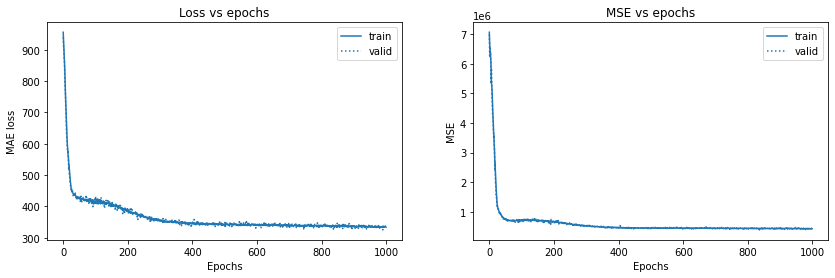

In [24]:
# Plot the learning curves

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(14, 4))

fig.add_subplot(121)
plt.plot(history.history['loss'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_loss'], label='valid', color='C0', linestyle=':')
plt.title("Loss vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MAE loss")
plt.legend()

fig.add_subplot(122)
plt.plot(history.history['mean_squared_error'], label='train', color='C0', linestyle='-')
plt.plot(history.history['val_mean_squared_error'], label='valid', color='C0', linestyle=':')
plt.title("MSE vs epochs")
plt.xlabel("Epochs")
plt.ylabel("MSE")
plt.legend()

plt.show()

## Plot the concentrations for a random exmple of the validation dataset

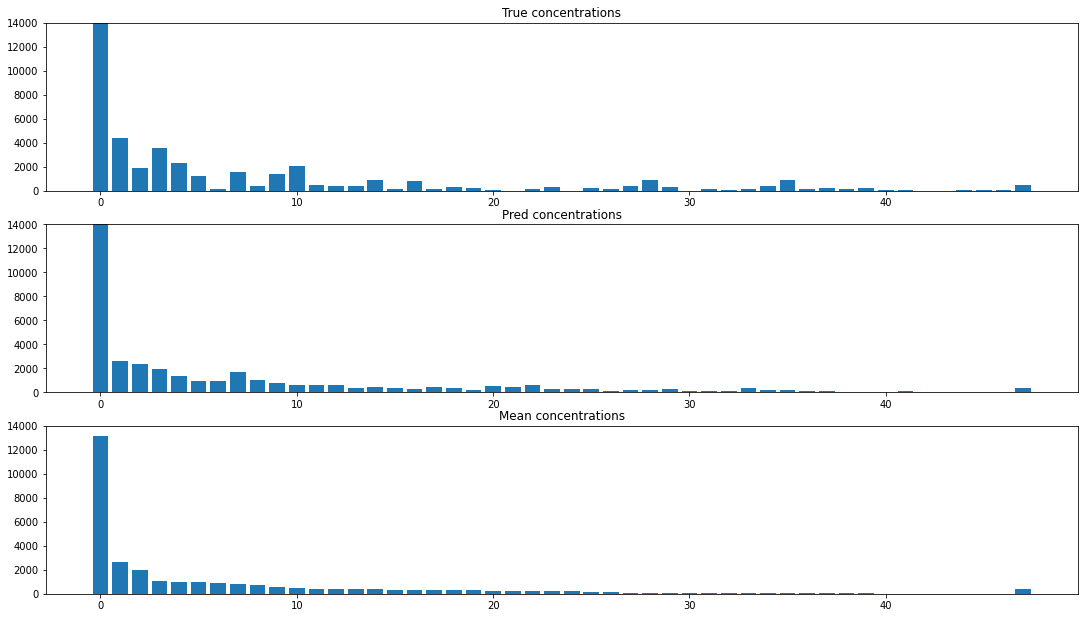

['Creatinine' 'Hippuric_acid' 'Citric_acid' 'Glycine' 'TMAO' 'Histidine'
 'phenylacetylglutamine' 'Taurine' 'glycolic_acid' 'Formate' 'Glutamine'
 'Lactate' 'lysine' 'cis-aconitic_acid' 'L_Tyrosine' 'Creatine'
 'Dimethylamine' 'guanidoacetic_acid' 'p-cresol_sulfate' 'L-alanine'
 'Arabitol' 'Isocitrate' 'Betaine' 'N-methylnicotinic_acid' 'acetate'
 'succinic_acid' 'Threonic_acid' 'Trimethylamine'
 'p-Hydroxyphenylacetic acid' 'beta-D-fructose' 'Dimethylglycine' 'NMND'
 '2-oxoglutarate' 'Galactose' 'Phenylacetate' 'L-carnosine' 'leucine'
 'Malic_acid' '2_hydroxybutyrate' 'Methionine' 'Isoleucine'
 'L-Glutamic_acid' 'citrulline' '2_deoxycytidine'
 'N-Acetyl-L-aspartic_acid' '2_deoxyadenosine' 'n-butyrate' 'L-serine']


In [77]:
import matplotlib.pyplot as plt
import numpy as np

filename_mean_concentrations = '../data/concentration_data/normal_urine.txt'
mean_concentrations = np.loadtxt(filename_mean_concentrations, delimiter='\t', dtype=float, usecols=1, skiprows=1)

filename_concentrations = '../data/concentration_data/Concentrations_Mix1.txt'
metabolites = np.loadtxt(filename_concentrations, delimiter='\t', dtype=str, usecols=0)

metab_number = range(48)
for parsed_record in val_dataset.shuffle(1000).take(1):
    true_concentration = parsed_record[1][0].numpy()
    pred_concentration = simple_model(parsed_record[0])[0].numpy()


fig, (ax1, ax2, ax3) = plt.subplots(3)
fig.set_size_inches(18.5, 10.5)

ax1.bar(metab_number,true_concentration)
ax1.set_title("True concentrations")
ax1.set_ylim(0, 14000)

ax2.bar(metab_number, pred_concentration)
ax2.set_title("Pred concentrations")
ax2.set_ylim(0, 14000)

ax3.bar(metab_number, mean_concentrations)
ax3.set_title("Mean concentrations")
ax3.set_ylim(0, 14000)

plt.show()

print(metabolites)

